# Quality Control (QC) and Data Cleaning

This notebook iterates over every kage in the dataset, loads the corresponding netCDF file, and generates QC plots to inspect daily frame counts and keypoint confidence distributions before cleaning. It then filters low-confidence detections, smooths positions with a rolling median filter, interpolates over small gaps, and writes the cleaned position data within the same netCDF file. QC figures and text logs are saved to each kage's reports directory.


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from movement.filtering import (
    filter_by_confidence,
    interpolate_over_time,
    rolling_filter,
)

from smart_kages_movement.plots import (
    plot_confidence_hist_per_keypoint,
    plot_confidence_quartiles_per_keypoint,
    plot_daily_qc,
    plot_missing_keypoints_heatmap,
)

## Configuration
Defines some global variables and plotting styles.

In [2]:
# For data cleaning
CONFIDENCE_THRESHOLD = 0.95  # point below the threshold will be dropped
ROLLING_WINDOW = 3  # frames (use for rolling median filter)
INTERPOLATION_MAX_GAP = 1  # frames (max gap to interpolate over)
RELIABLE_KEYPOINT = "bodycenter"


# Configure seaborn for prettier plots
sns.set_context("notebook")
sns.set_style("ticks")

Define paths to the `movement_analysis` directory and the `all_segments.csv` file.
Also find all kage folders in the analysis directory.

In [3]:
analysis_dir = Path("/mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/movement_analysis")

if not analysis_dir.exists():
    print(f"Path does not exist: {analysis_dir}")

# List of all `kageID` folder in analysis_dir
kage_names = [
    d.name for d in analysis_dir.iterdir() if d.is_dir() and d.name.startswith("kage")
]
print(f"Found {len(kage_names)} kage folders in {analysis_dir}:\n")
# Print 5 kages per line
for i in range(0, len(kage_names), 5):
    print(", ".join(kage_names[i : i + 5]))

Found 33 kage folders in /mnt/Data/Smart-Kages/2024-04-Apr-May-Downs/movement_analysis:

kage1, kage10, kage11, kage12, kage13
kage14, kage15, kage16, kage17, kage18
kage19, kage2, kage20, kage21, kage22
kage23, kage24, kage25, kage26, kage27
kage28, kage29, kage3, kage30, kage31
kage32, kage33, kage4, kage5, kage6
kage7, kage8, kage9


## Quality Control (QC) reports
Plot some metrics to help us decide which data to include in the analysis.

These metrics include:
- Total number of frames (time-points) per day
- Number of empty frames per day (frames with all keypoints missing)
- Median `bodycenter` confidence per day (`bodycenter` is the most reliably detected keypoint, so a drop in its confidence likely indicates a problem with the recording).
- Confidence quartiles per keypoint
- Confidence histograms per keypoint

## Cleaning

- Filter by confidence
- Smooth with a rolling median filter
- Interpolate missing values

After cleaning, plot a heatmap of % missing values per keypoint and per day, to see how much data was lost during cleaning.

## Saved data
The cleaned position data is saved to a new variable name `position_clean` and written to the same netCDF file as the raw data, for later use.

Reports are saved as PNG files (figures), often accompanied by corresponding CSV files (metrics).


Processing kage1...
Cleaning log found for kage1, skipping...

Processing kage10...
Cleaning log found for kage10, skipping...

Processing kage11...
Cleaning log found for kage11, skipping...

Processing kage12...
Cleaning log found for kage12, skipping...

Processing kage13...
Cleaning log found for kage13, skipping...

Processing kage14...
Cleaning log found for kage14, skipping...

Processing kage15...
Cleaning log found for kage15, skipping...

Processing kage16...
Cleaning log found for kage16, skipping...

Processing kage17...
Cleaning log found for kage17, skipping...

Processing kage18...
Cleaning log found for kage18, skipping...

Processing kage19...
Cleaning log found for kage19, skipping...

Processing kage2...
Cleaning log found for kage2, skipping...

Processing kage20...
Cleaning log found for kage20, skipping...

Processing kage21...
Cleaning log found for kage21, skipping...

Processing kage22...
Cleaning log found for kage22, skipping...

Processing kage23...
Generat

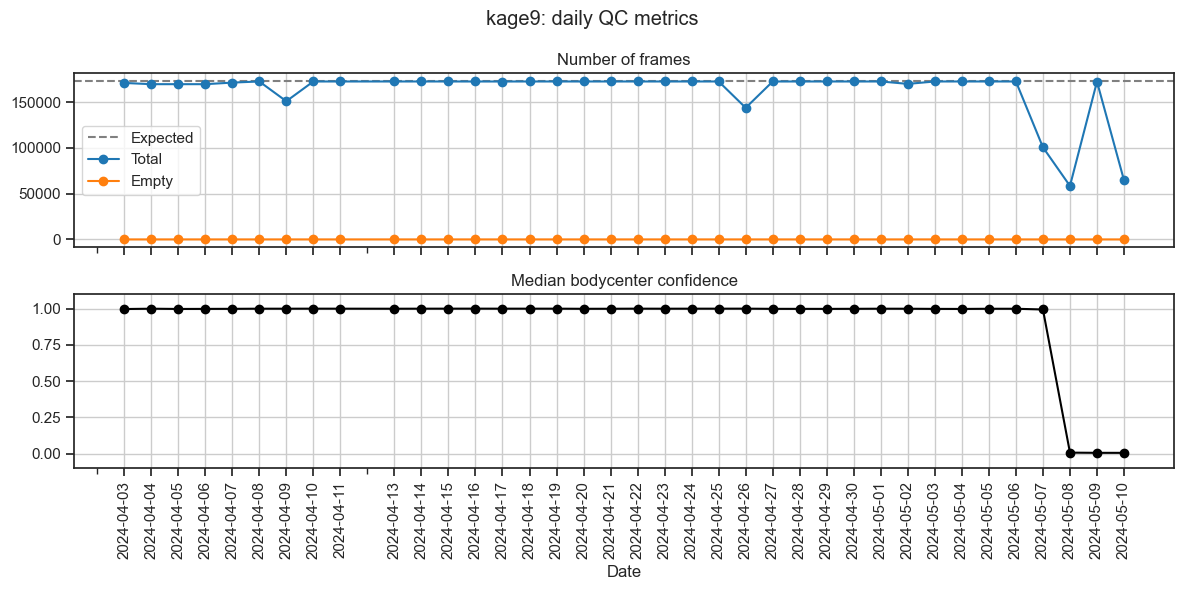

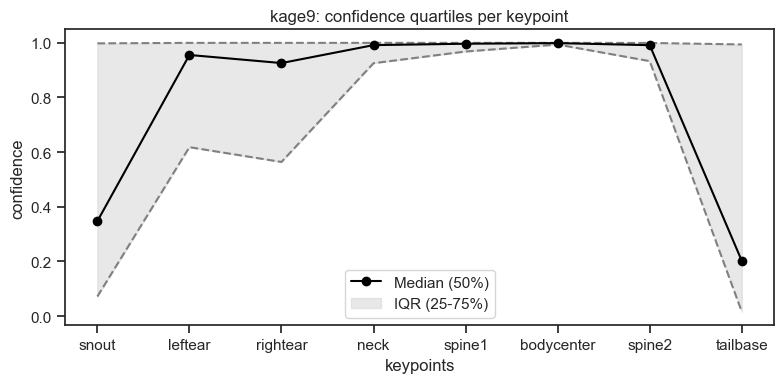

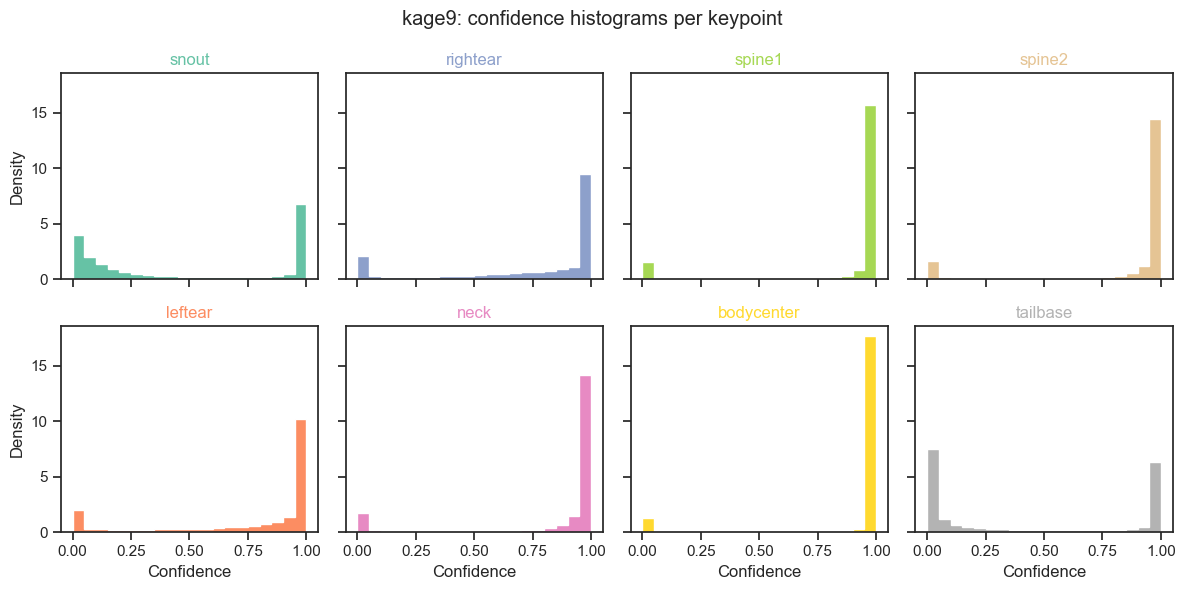

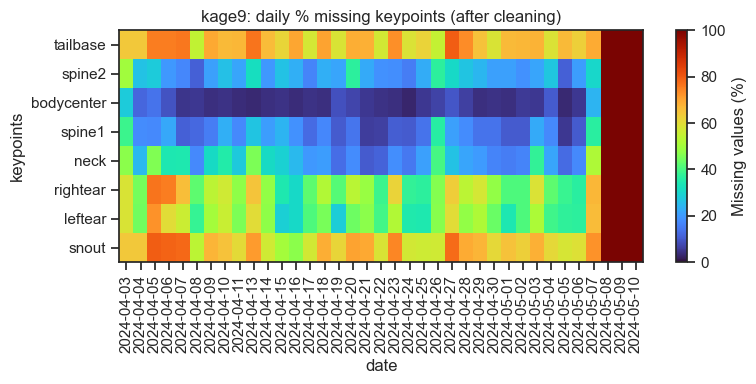

In [13]:
for i, kage in enumerate(kage_names):
    print(f"\nProcessing {kage}...")

    # Where to save the reports
    kage_dir = analysis_dir / kage
    kage_reports_dir = kage_dir / "reports"
    kage_reports_dir.mkdir(exist_ok=True)

    # Skip kages that have already been cleaned
    if (kage_dir / "cleaning_logs.txt").exists():
        print(f"Cleaning log found for {kage}, skipping...")
        continue

    # Load dataset
    ds_kage = xr.load_dataset(kage_dir / f"{kage}.nc")

    # Correct source_file attribute
    ds_kage.attrs["source_file"] = (kage_dir / f"{kage}.nc").as_posix()

    # Extract position and confidence DataArrays
    position = ds_kage["position"]
    confidence = ds_kage["confidence"]

    # --- QC plots before cleaning ---

    print("Generating QC plots before cleaning...")

    plot_daily_qc(
        ds_kage,
        keypoint=RELIABLE_KEYPOINT,
        save_path=kage_reports_dir / f"{kage}_daily_qc.png",
    )

    plot_confidence_quartiles_per_keypoint(
        ds_kage,
        save_path=kage_reports_dir / f"{kage}_confidence_quartiles.png",
    )

    plot_confidence_hist_per_keypoint(
        ds_kage,
        save_path=kage_reports_dir / f"{kage}_confidence_histograms.png",
    )

    print(f"Saved QC plots and reports to: {kage_reports_dir}.")

    # --- Data cleaning steps go here ---

    print("Cleaning data...")
    # 1. Filter by confidence
    position_thr = filter_by_confidence(
        position,
        confidence,
        threshold=CONFIDENCE_THRESHOLD,
    )

    # 2. Smooth with a rolling median filter
    position_smoothed = rolling_filter(
        position_thr,
        statistic="median",
        window=ROLLING_WINDOW,
        min_periods=2,
    )

    # 3. Interpolate gaps of up to 1 frame
    position_clean = interpolate_over_time(
        position_smoothed,
        method="linear",
        max_gap=INTERPOLATION_MAX_GAP,
    )

    # Plot heatmap of % missing keypoints per day after cleaning
    plot_missing_keypoints_heatmap(
        position_clean,
        kage_name=kage,
        title_str="daily % missing keypoints (after cleaning)",
        cmap="turbo",
        save_path=kage_reports_dir / f"{kage}_missing_keypoints_heatmap.png",
    )
    print(f"Saved missing keypoints heatmap to: {kage_reports_dir}.")

    # Save cleaned data
    ds_kage["position_clean"] = position_clean
    ds_kage.to_netcdf(kage_dir / f"{kage}.nc")
    print(f"Saved 'position_clean' variable to: {kage_dir / f'{kage}.nc'}.")

    # Save the cleaning logs to a file
    with open(kage_dir / "cleaning_logs.txt", "w") as f:
        f.write(ds_kage["position_clean"].log)
    print(f"Saved cleaning logs to: {kage_dir / 'cleaning_logs.txt'}.")

    # End of processing for this kage
    print(f"Done with {kage}.")
    print("-" * 40)

    # Free up memory
    if i != len(kage_names) - 1:
        del ds_kage
        plt.close("all")
    else:
        print("\nFinished processing all kages.")